In [1]:
using Pkg
Pkg.activate("/home/tara/julia_codes/SmallCouplingDynamicCavity/")

  Activating project at `~/julia_codes/SmallCouplingDynamicCavity`


In [2]:
using Plots, LaTeXStrings
using Graphs, GraphRecipes
using SmallCouplingDynamicCavity
using SparseArrays
using Random
using JLD

## $\rho$ visualization

### Data loading

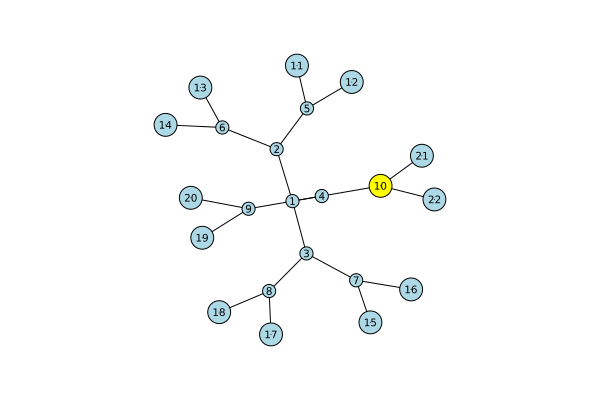

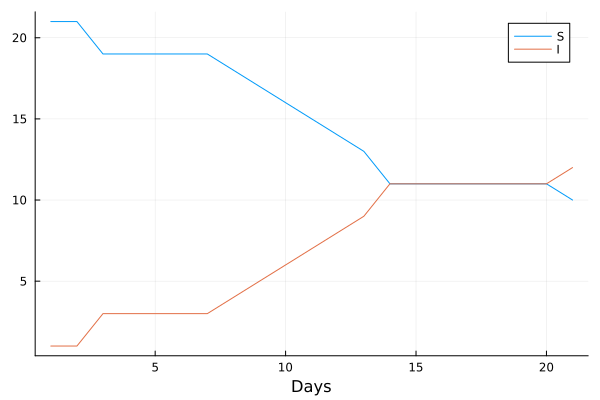

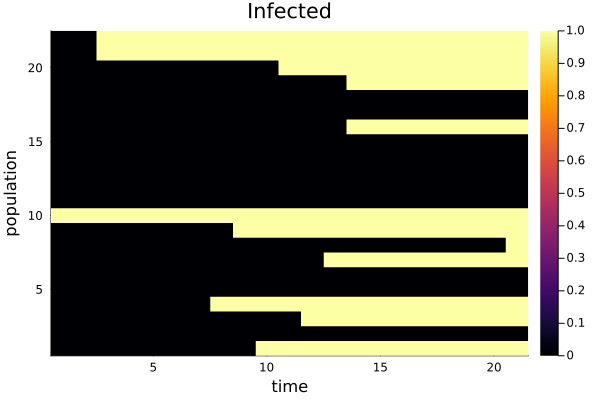

In [3]:
data = load("rho_supershort_tree.jld")
G = data["G"]
NV::Int = nv(G)
config::Array{Float64, 2} = data["config"]
T::Int = data["T"]
λ₀::Float64 = data["lambda"]
γ::Float64 = 1/NV # Patient zero probability
observed = data["observed"]

isource = findall(x->x==1.0,config[:,1])

cols = [:blues for _ in 1:NV]
cols[isource] .= :yellow

display(graphplot(G,names=1:NV,edgecolor=:black,curves=false,markercolor=cols,nodeshape=:circle, markersize =.2))

# infected individuals over time
nrI = dropdims(sum(map(x->Float64(x==1.0),config), dims = 1), dims = 1)
nrS = dropdims(sum(map(x->Float64(x==0.0),config), dims = 1), dims = 1)
#nrR = dropdims(sum(map(x->Float64(x==2.0),config), dims = 1), dims = 1)
display(plot([nrS nrI], xlabel = "Days", ylabel = "", label = ["S" "I"]))

# display epidemy
display(heatmap(config,title="Infected",xlabel="time",ylabel="population")) 

### Inference SCDC-- autoinfection, $\mu$ cutoff

In [4]:
# computational constants
const epsconv::Float64 = 5e-15 # convergence threshold
const maxiter::Int = 5e2 # max number of iterations
damp::Float64 = 0.0 # damping factor
μ_cutoff::Float64 = -Inf
ε_autoinf::Float64 = 0.0

# define the observation probability
function obsprob(Ob::Float64, x::Float64)
    if Ob == -1.0
        return 1.0
    else
        return Float64(Ob == x)
    end
end

# constant infection probability
λ = zeros(NV, NV, T+1)
for e in edges(G)
    λ[src(e), dst(e), :] = ones(T+1) * λ₀
    λ[dst(e), src(e), :] = ones(T+1) * λ₀
end

# callback function
function report(nodes,iter,ε) 
    println("i = ", iter,  " ε = ", ε)
end

report (generic function with 1 method)

Any[(1, 8)]
i = 1 ε = 0.978972460784287
i = 2 ε = 0.5535689781690896
i = 3 ε = 0.2673093317229257
i = 4 ε = 0.006804072102218672
i = 5 ε = 0.0
Converged after 5 iterations
Any[(1, 12)]
i = 1 ε = 7.634787143138911
i = 2 ε = 5.768609605540932
i = 3 ε = 1.1898023399379345
i = 4 ε = 0.023722197042346682
i = 5 ε = 0.0
Converged after 5 iterations


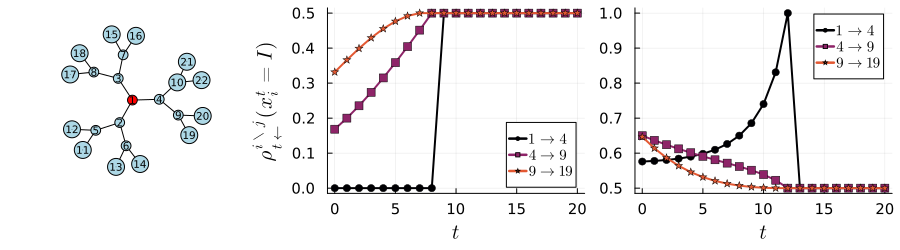

In [5]:
mark = [:circle, :square, :star, :utriangle, :diamond, :cross]
g = cgrad(:inferno)
col = [g[1], g[100], g[160], g[190], g[210], g[240]]

path = [1, 4, 9, 19]


######## Susceptible ##############
t_obs = 8 #ceil(Int,T/2)+

# generate observations
obsmat = ones(NV, T+1) * (-1.0)
obslist = []
for iₗ in observed
    obsmat[iₗ, t_obs+1] = config[iₗ, t_obs+1]
    push!(obslist, (iₗ, ceil(Int,t_obs)))
end
println(obslist)

nodes = run_SCDC(G, λ, obsmat, obsprob, γ, T, maxiter, epsconv, damp, :SI, callback = report, μ_cutoff = μ_cutoff, ε_autoinf = ε_autoinf);

index = 1
i = path[1]
j = path[2]
p1 = plot(0:T, nodes[j].ρs[nodes[j].∂_idx[i]].bwm[2,:], label=L"%$i \rightarrow %$j", color=col[index], width=2, markers=mark[index])
for i in path[2:end-1]
    index += 1
    j = path[index+1]
    plot!(p1, 0:T, nodes[j].ρs[nodes[j].∂_idx[i]].bwm[2,:], label=L"%$i \rightarrow %$j", color=col[index], width=2, markers=mark[index])
end
plot!(p1, guidefontsize=14, ylabel=L"\rho_{t\leftarrow}^{i\setminus j}(x_i^t=I)", xtickfontsize=10, ytickfontsize=10, yformatter = :plain, xlabel=L"t")



######### Infected ###################
t_obs = 12 #ceil(Int,T/2)+

# generate observations
obsmat = ones(NV, T+1) * (-1.0)
obslist = []
for iₗ in observed
    obsmat[iₗ, t_obs+1] = config[iₗ, t_obs+1]
    push!(obslist, (iₗ, ceil(Int,t_obs)))
end
println(obslist)

nodes = run_SCDC(G, λ, obsmat, obsprob, γ, T, maxiter, epsconv, damp, :SI, callback = report, μ_cutoff = μ_cutoff, ε_autoinf = ε_autoinf);

index = 1
i = path[1]
j = path[2]
p2 = plot(0:T, nodes[j].ρs[nodes[j].∂_idx[i]].bwm[2,:], label=L"%$i \rightarrow %$j", color=col[index], width=2, markers=mark[index])
for i in path[2:end-1]
    index += 1
    j = path[index+1]
    plot!(p2, 0:T, nodes[j].ρs[nodes[j].∂_idx[i]].bwm[2,:], label=L"%$i \rightarrow %$j", color=col[index], width=2, markers=mark[index])
end
plot!(p2, guidefontsize=14, xtickfontsize=10, ytickfontsize=10, yformatter = :plain, xlabel=L"t")


########### final plot #####################
cols = [:blues for _=1:NV]
cols[observed] .= :red
pgraph = graphplot(G, markercolor=cols, names=1:NV, markersize = 0.20, edgecolor=:black, curves=false, nodeshape=:circle, label = "", size=(400,400))

ptot = plot(pgraph, p1, p2, layout = (1, 3), legend = true, legendfontsize=10, size = (900, 250), margin=0Plots.mm, bottommargin=7Plots.mm, axis_buffer=0.001)
display(ptot)

#savefig(ptot, "rhos_backward_900x250.pdf")

## $\mu$ visualization

In [18]:
k = 3 # number of graph vertices
tmax = 5

V,E = bethe_lattice(k,tmax,true) ; NV= length(V)
G = SimpleGraph(Edge.([(x[1],x[2]) for x in E]))

# in this cell I create some random links to introduce some loops on the graph G which is a Tree
for st = 1:NV*.1
    i = rand(1:NV)
    i == NV && continue
    j = rand(i+1:NV)
    add_edge!(G,i,j)
    add_edge!(G,j,i) 
end

## - SIRS:

### System parameter definition and simulation

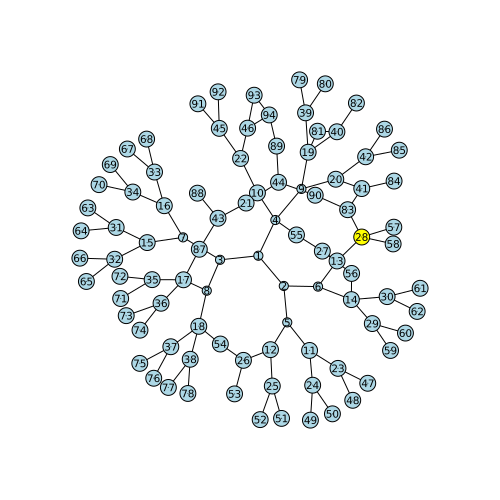

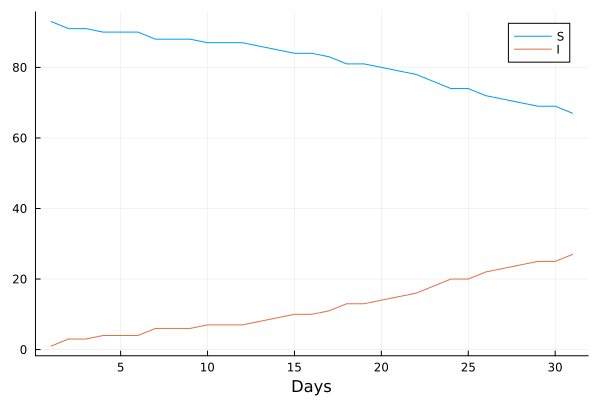

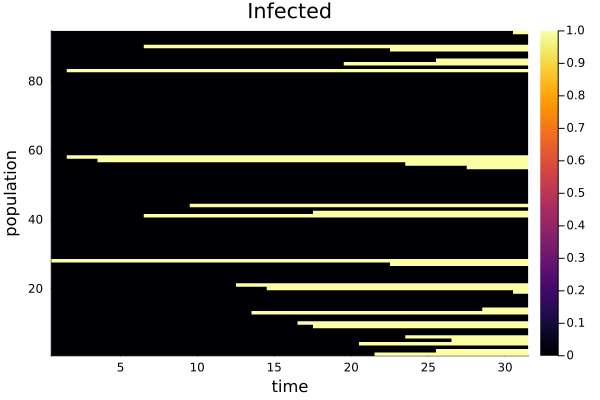

In [17]:
# define the constants
T::Int = 30 # total time
γ::Float64 = 1/NV # Patient zero probability
λ₀::Float64 = 0.1 # Infection rate

# define the observation probability
function obsprob(Ob::Float64, x::Float64)
    if Ob == -1.0
        return 1.0
    else
        return Float64(Ob == x)
    end
end

# constant infection probability
λ = zeros(NV, NV, T+1)
for e in edges(G)
    λ[src(e), dst(e), :] = ones(T+1) * λ₀
    λ[dst(e), src(e), :] = ones(T+1) * λ₀
end

# epidemic simulation
config = sim_epidemics(G, log.(1 .- λ), T, :SI, γ=γ)
#display(perm_sort)
#display(config)
#display(config[perm_sort,:])

isource = findall(x->x==1.0, config[:,1])

cols = [:blues for _ in 1:NV]
cols[isource] .= :yellow

#Random.seed!(1998)
display(graphplot(G, names=1:NV, edgecolor=:black,curves=false,markercolor=cols,nodeshape=:circle, markersize =.12, size=(500,500)))

# infected individuals over time
nrI = dropdims(sum(map(x->Float64(x==1.0),config), dims = 1), dims = 1)
nrS = dropdims(sum(map(x->Float64(x==0.0),config), dims = 1), dims = 1)
#nrR = dropdims(sum(map(x->Float64(x==2.0),config), dims = 1), dims = 1)
display(plot([nrS nrI], xlabel = "Days", ylabel = "", label = ["S" "I"]))

# display epidemy
display(heatmap(config,title="Infected",xlabel="time",ylabel="population")) 

### Generation of observations

In [9]:
t_obs = 25

println(config[1,t_obs+1])
println(config[5,t_obs+1])

1.0
1.0


In [165]:
#using JLD
#save("mus_graph.jld", "G", G, "config", config)

### Inference SCDC-- autoinfection, $\mu$ cutoff

In [166]:
# computational constants
const epsconv::Float64 = 5e-15 # convergence threshold
const maxiter::Int = 5e2 # max number of iterations
const damp::Float64 = 0.0 # damping factor
const μ_cutoff::Float64 = -Inf
const ε_autoinf::Float64 = 0.0

# callback function
function report(nodes,iter,ε) 
    println("i = ", iter,  " ε = ", ε)
end

report (generic function with 1 method)

In [ ]:
####### 1 ob #############
observed1 = [1]

# generate observations
obsmat = ones(NV, T+1) * (-1.0)
obslist = []
for iₗ in observed1
    obsmat[iₗ, t_obs+1] = config[iₗ, t_obs+1]
    push!(obslist, (iₗ, ceil(Int,t_obs)))
end
println(obslist)

nodes1 = run_SCDC(G, λ, obsmat, obsprob, γ, T, maxiter, epsconv, damp, :SI, μ_cutoff = μ_cutoff, ε_autoinf = ε_autoinf)



######### 2 obs #############
observed2 = [1, 5]

# generate observations
obsmat = ones(NV, T+1) * (-1.0)
obslist = []
for iₗ in observed2
    obsmat[iₗ, t_obs+1] = config[iₗ, t_obs+1]
    push!(obslist, (iₗ, ceil(Int,t_obs)))
end
println(obslist)

nodes2 = run_SCDC(G, λ, obsmat, obsprob, γ, T, maxiter, epsconv, damp, :SI, μ_cutoff = μ_cutoff, ε_autoinf = ε_autoinf)

Any[(1, 25)]


In [201]:
function norm_μ(i::Int,j::Int,nodes::Vector)
    iindex = nodes[j].∂_idx[i]  #calculate the norm of μ at node i for the j_th coNVection
    sqrt(sum((nodes[j].cavities[iindex].μ[t_obs-4]) .^ 2))
end

norm_μ (generic function with 1 method)

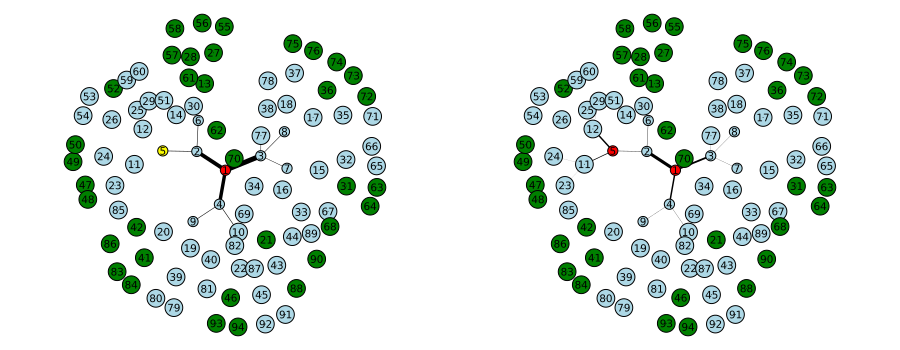

In [202]:
using Random

spess = [5, 5, 10, 10, 10, 10, 60]

######## 1 obs ##############
μ = zeros(NV,NV)
for e in edges(G)
    i = src(e)
    j = dst(e)
    μ[i,j] += norm_μ(i,j,nodes1)
#    μ[j,i] += norm_μ(j,i,nodes)
end
μ .+= μ'

cols = [config[i,end]==1.0 ? :blues : :green for i=1:NV]
cols[isource] .= :yellow
cols[observed1] .= :red
μs = spess[length(observed)] * sparse((μ) ./ maximum(μ)) #qui ci metto lo spessore
Random.seed!(1998)
p1 = graphplot(G; edgewidth=(s,d,w) -> μs[s,d], names=1:NV, markercolor=cols, markersize = 0.18, edgecolor=:black, curves=false, nodeshape=:circle, axisbuffer=0.05)



######## 2 obs ##############
μ = zeros(NV,NV)
for e in edges(G)
    i = src(e)
    j = dst(e)
    μ[i,j] += norm_μ(i,j,nodes2)
#    μ[j,i] += norm_μ(j,i,nodes)
end
μ .+= μ'


cols = [config[i,end]==1.0 ? :blues : :green for i=1:NV]
cols[isource] .= :yellow
cols[observed2] .= :red
μs = spess[length(observed)] * sparse((μ))# ./ maximum(μ)) #qui ci metto lo spessore
Random.seed!(1998)
p2 = graphplot(G; edgewidth=(s,d,w) -> μs[s,d], names=1:NV, markercolor=cols, markersize = 0.18, edgecolor=:black, curves=false, nodeshape=:circle, axisbuffer=0.05)

########### final plot #####################
ptot = plot(p1, p2, layout = (1, 2), size = (900, 350), margin=0Plots.mm)
display(ptot)

#savefig(ptot, "mus_900x350.pdf")

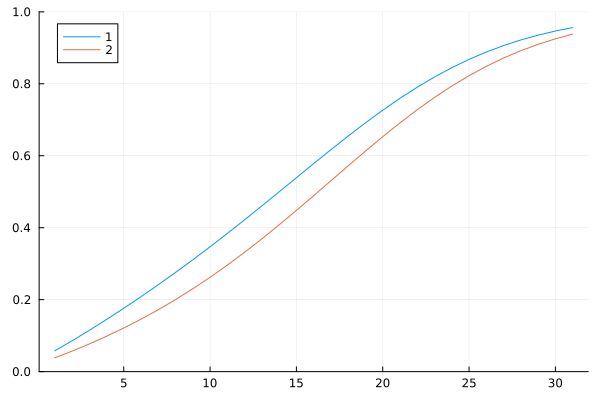

In [185]:
display(plot([1:T+1 1:T+1], [nodes1[8].marg.m[2,:] nodes2[8].marg.m[2,:]], label=["1" "2"], ylim=(0,1)))
#display(plot(nodes1[18].marg.m[2,:], ylim=(0,1)))
#display(plot(nodes1[37].marg.m[2,:], ylim=(0,1)))

#display(plot(nodes2[8].marg.m[2,:], ylim=(0,1)))
#display(plot(nodes2[18].marg.m[2,:], ylim=(0,1)))
#display(plot(nodes2[37].marg.m[2,:], ylim=(0,1)))

In [ ]:
function sort_by_infection_time(X, T, NV)
    inf_tuples = Dict()
    first_time_inf = ones(Int, NV).*(T+1)
    for i=1:NV
        t1 = 0
        t2 = 0
        inf = false
        for t=0:T
            if X[i,t+1]==1.0 && !inf
                t1 = t
                inf = true
            elseif X[i,t+1]==2.0 && inf
                t2 = t
                if !haskey(inf_tuples, i)
                    merge!(inf_tuples, Dict(i=>[(t1,t2)]))
                    first_time_inf[i] = t1
                else
                    push!(inf_tuples[i],(t1,t2))
                end
                inf = false
            else
                continue
            end
        end
        if inf
            if !haskey(inf_tuples, i)
                merge!(inf_tuples, Dict(i=>[(t1,T)]))
                first_time_inf[i] = t1
            else
                push!(inf_tuples[i],(t1,T))
            end
        end
    end
    #display(first_time_inf)
    perm = sortperm(first_time_inf)
    
    return inf_tuples, invperm(perm), perm
end

pgfplotsx()

cols = [:white, :red, :black]
resize_factor = 1.0
cg = cgrad([:dodgerblue, :yellow], 0.6)



plI_SCDC = heatmap(1:NV, 0:T, marg_prob[:,:,2]', c=cg, xlabel=L"i", ylabel=L"t", colorbar_title=L"p(x_i^t=I)", yrange=(0,T), xticks=1:5:NV, framestyle = :box)#, title = "Infected")

for (i, inf_time_list) in inf_tuples
    for inf_time in inf_time_list
        plot!(plI_SCDC, [invperm_sort[i],invperm_sort[i]], [inf_time[1]-0.1,inf_time[2]+0.1], c=:black, label="", lw=1)
    end
end

for (i,t) in obslist
    scatter!(plI_SCDC, [invperm_sort[i]], [t], ms=2, msc=:black, c=cols[ceil(Int,config[i,t+1])+1], label="")
end

#println("Observations at times: ", obs_times)
plot!(plI_SCDC, yticks=0:(T÷5):T, widen=false, margin=3Plots.mm, size=(900,250).*resize_factor)